In [1]:
push!(LOAD_PATH, pwd()*"/../src")
using CMBFields
using PyPlot
using ProfileView
using BenchmarkTools

INFO: Recompiling stale cache file /home/marius/.julia/lib/v0.6/ProfileView.ji for module ProfileView.
INFO: Recompiling stale cache file /home/marius/.julia/lib/v0.6/ProfileViewSVG.ji for module ProfileViewSVG.


In [2]:
cls = class(lmax=4000);

In [20]:
T, θpix, nside = Float32, 1, 256
P = Flat{θpix,nside}

CMBFields.Flat{1,256}

In [21]:
Cf = Cℓ_to_cov(T,P,S0,S2,cls[:ℓ],cls[:tt],cls[:te],cls[:ee],cls[:bb])
Cϕ = Cℓ_to_cov(T,P,S0,cls[:ℓ],cls[:ϕϕ])

CMBFields.FullDiagOp{CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,256}},CMBFields.Flat{1,256},CMBFields.S0,CMBFields.Fourier}(CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,256}}(Complex{Float32}[0.0+0.0im 1.72271f-14+0.0im … 6.51402f-16+0.0im 1.72271f-14+0.0im; 1.72271f-14+0.0im 3.48355f-15+0.0im … 3.7436f-16+0.0im 3.48355f-15+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im]))

In [22]:
L=LenseFlow(simulate(Cϕ),CMBFields.ode4{7});
f=Ł(simulate(Cf));

In [23]:
@benchmark $L*$f

BenchmarkTools.Trial: 
  memory estimate:  268.96 MiB
  allocs estimate:  92476
  --------------
  minimum time:     313.707 ms (9.35% GC)
  median time:      338.666 ms (8.75% GC)
  mean time:        358.368 ms (15.37% GC)
  maximum time:     453.902 ms (34.67% GC)
  --------------
  samples:          14
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [24]:
Profile.init(delay=1e-3)
Profile.clear()

In [25]:
@profile L*f

CMBFields.Field2Tuple{CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,256}},CMBFields.FlatS2QUFourier{Float32,CMBFields.Flat{1,256}},CMBFields.Fourier,CMBFields.QUFourier}(CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,256}}(Complex{Float32}[0.00193227+0.0im 0.00105835+0.00062368im … 0.00104023+0.000575778im 0.00105835-0.00062368im; -0.00607589+0.0114184im -0.0116362+0.0188774im … -0.00752901+0.00983723im -0.0141131-0.011345im; … ; -1.02104f-9+7.58448f-10im -1.81605f-9-3.58609f-10im … -3.35695f-10+2.1306f-10im -6.85227f-10-1.42809f-9im; -3.85124f-9+0.0im -5.7597f-10-3.13476f-9im … -1.22345f-9-6.40739f-9im -5.7597f-10+3.13476f-9im]), CMBFields.FlatS2QUFourier{Float32,CMBFields.Flat{1,256}}(Complex{Float32}[1.98939f-5+0.0im -5.10286f-5-0.00031274im … -0.000181923+0.00037437im -5.10286f-5+0.00031274im; -4.97929f-5-4.10789f-5im -4.02263f-5+7.29301f-6im … -0.000191923+1.8514f-5im 2.88293f-5-1.04608f-5im; … ; 7.7671f-11-9.02126f-11im 3.60597f-11+5.79897f-10im … -5.29664f-10-1.73329f-10im 

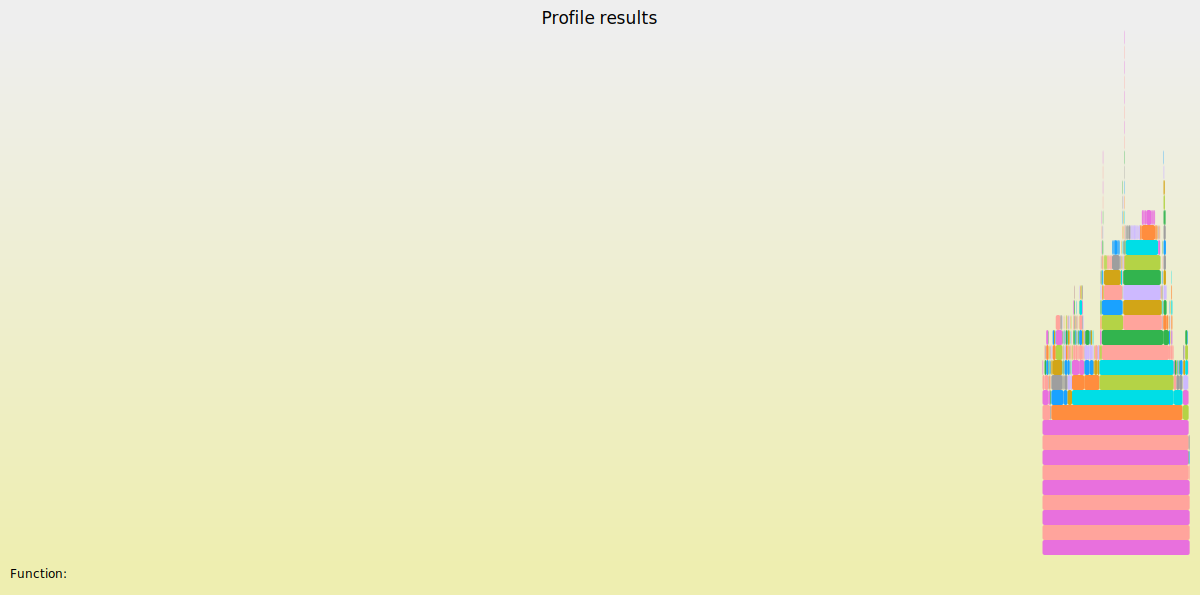

In [182]:
ProfileView.view()

In [166]:
runtimes = map(5:12) do i
    f = simulate(Cℓ_to_cov(T,Flat{1,2^i},S0,S2,cls[:ℓ],cls[:tt],cls[:te],cls[:ee],cls[:bb]))
    ϕ = simulate(Cℓ_to_cov(T,Flat{1,2^i},S0,cls[:ℓ],cls[:ϕϕ]))
    (@elapsed LenseFlow(ϕ,CMBFields.ode4{7})*f), (@elapsed PowerLens(ϕ,order=2)*f)
end

8-element Array{Tuple{Float64,Float64},1}:
 (0.0780254, 0.00554386)
 (0.103537, 0.00686047) 
 (0.139502, 0.011346)   
 (0.360098, 0.0349957)  
 (1.50043, 0.123021)    
 (8.21532, 0.577372)    
 (32.9688, 3.4016)      
 (175.142, 13.3358)     

In [141]:
using PyCall
using PyPlot
@pyimport seaborn as sns
sns.set_context("notebook",font_scale=1.4,rc=Dict("lines.markeredgewidth"=>1))
sns.set_palette("colorblind")
@pyimport matplotlib as mpl

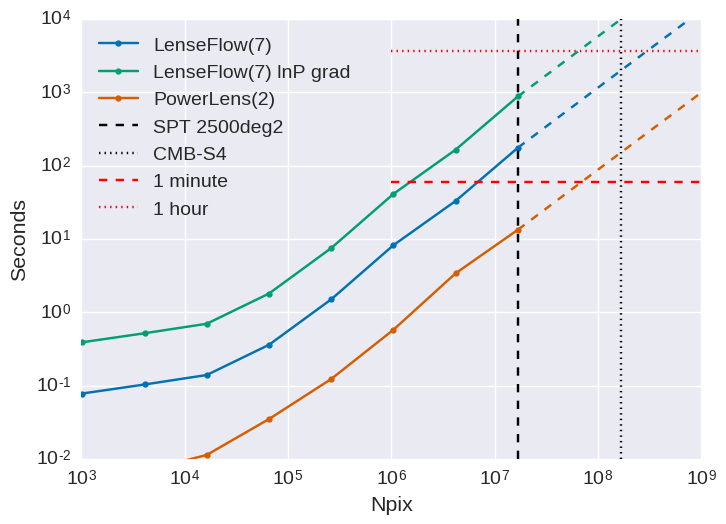

PyObject <matplotlib.text.Text object at 0x7f0415b06690>

In [181]:
p1 = loglog((2.^(5:12)).^2, getindex.(runtimes,1),".-",label="LenseFlow(7)")
p2 = loglog((2.^(5:12)).^2, 5getindex.(runtimes,1),".-",label="LenseFlow(7) lnP grad")
p3 = loglog((2.^(5:12)).^2, getindex.(runtimes,2),".-",label="PowerLens(2)")


Npix = (2.^(12:15)).^2
loglog(Npix, (@. getindex.(runtimes,1)[end]*(Npix*log(Npix)/(Npix[1]*log(Npix[1])))),"--",c=p1[1][:get_color]())
loglog(Npix, (@. 5getindex.(runtimes,1)[end]*(Npix*log(Npix)/(Npix[1]*log(Npix[1])))),"--",c=p2[1][:get_color]())
loglog(Npix, (@. getindex.(runtimes,2)[end]*(Npix*log(Npix)/(Npix[1]*log(Npix[1])))),"--",c=p3[1][:get_color]())

plot(fill(4096^2,2),[1e-2,1e4],"k--",label="SPT 2500deg2")
plot(fill(4096^2*10,2),[1e-2,1e4],"k:",label="CMB-S4")
plot([1e6,1e9],fill(60,2),"r--",label="1 minute")
plot([1e6,1e9],fill(60*60,2),"r:",label="1 hour")
legend(loc="upper left", ncol=1)
ylim(1e-2,1e4)
xlim(1e3,1e9)

xlabel("Npix")
ylabel("Seconds")

Note: A Planck map at Nside=2048 has only about 3 times the number of pixels as SPT 2500deg2, but spherical transforms scale as N^3/2 instead of N log N, and with a worse prefactor, so this could potentially be really bad....

We do about O(50) evaluations of the velocity term per ODE run, but they all have to run sequentially. Some ideas for speed improvements,

* Parallelize the ∇ϕ' * (1 + tJϕ)⁻¹ computation (which we can do since for fixed step ODE we know all of the t's at which we need to evaluate it; will this really help, or is the bottleneck the fourier transforms of f? certainly for full-sky it'll likely be the latter; memory concerns here as well)
* Keep ϕ map only to low resolution (again, is that the bottleneck?)
* Generic parallel Runge-Kutta via block diagonal tableau (factor ~2,3 at best?)
* Parareal or ParaExp algorithms (need to look into, not clear there would be speedup given our low number of evals)
* GPUs (then I also need access to a cluster with GPU machines, which NERSC probably has but still...)
